# Comparing methods to simulate Ornstein-Uhlenbeck bridge 

In [1]:
import DiffusionBridge as db
import torch
import matplotlib.pyplot as plt
from DiffusionBridge.utils import normal_logpdf
plt.style.use('ggplot')

In [2]:
# problem settings
d = 1
alpha = torch.tensor(0.0)
beta = torch.tensor(2.0)
# f = lambda t,x: alpha - beta * x 
f = lambda t,x: 0
sigma = torch.tensor(1.0)
T = torch.tensor(1.0)
M = 50
diffusion = db.diffusion.model(f, sigma, d, T, M)

from utils.data import Gaussian, twoGaussian

source_dist = Gaussian()
target_dist = twoGaussian()
X0 = source_dist(100)
XT = target_dist(100)

# initial and terminal constraints
# X0 = 1.0 * torch.ones(d)
# XT = 10 * torch.ones(d)

# transition density
# ratio = alpha / beta
# transition_mean = lambda t,x: ratio + (x - ratio) * torch.exp(- beta * t)
# transition_var = lambda t: (1.0 - torch.exp(-2.0 * beta * t)) / (2.0 * beta)
# score_transition = lambda t,x: (transition_mean(t, X0) - x) / transition_var(t)
# log_transition_density = normal_logpdf(XT.reshape(1, d), transition_mean(T, X0), transition_var(T))
# print('log-transition density: ' + str(float(log_transition_density)))

# # marginal density
# marginal_var = lambda t: 1.0 / (1.0 / transition_var(t) + torch.exp(- 2.0 * beta * (T-t)) / transition_var(T-t))
# marginal_mean = lambda t: (transition_mean(t,X0) / transition_var(t) + XT * torch.exp(- beta * (T-t)) / transition_var(T-t)) * marginal_var(t) 
# score_marginal = lambda t,x: (marginal_mean(t) - x) / marginal_var(t)
# grad_logh = lambda t,x: (XT - transition_mean(T - t, x)) * torch.exp(- beta * (T - t)) / transition_var(T - t)

# repetitions
N = 2**10
R = 100


In [3]:
# learn backward diffusion bridge process with score matching
epsilon = 0
minibatch = 100
num_iterations = 5000
learning_rate = 0.001
ema_momentum = 0.99
output = diffusion.learn_full_score_transition(source_dist, XT, epsilon,1, minibatch, num_iterations, learning_rate, ema_momentum)
score_transition_net = output['net']

# # simulate backward diffusion bridge (BDB) process with approximate score
# BDB = {'ess' : torch.zeros(R), 'logestimate' : torch.zeros(R), 'acceptrate' : torch.zeros(R)}
# for r in range(R):
#     with torch.no_grad():
#         output = diffusion.simulate_bridge_backwards(score_transition_net, X0, XT, epsilon, N, modify = False)
#         trajectories = output['trajectories']
#         log_proposal = output['logdensity']
#     log_target = diffusion.law_bridge(trajectories) 
#     log_weights = log_target - log_proposal
    
#     # importance sampling
#     max_log_weights = torch.max(log_weights)
#     weights = torch.exp(log_weights - max_log_weights)
#     norm_weights = weights / torch.sum(weights)
#     ess = 1.0 / torch.sum(norm_weights**2)
#     log_transition_estimate = torch.log(torch.mean(weights)) + max_log_weights
#     BDB['ess'][r] = ess
#     BDB['logestimate'][r] = log_transition_estimate
    
#     # independent Metropolis-Hastings
#     initial = diffusion.simulate_bridge_backwards(score_transition_net, X0, XT, epsilon, 1, modify = False)
#     current_trajectory = initial['trajectories']
#     current_log_proposal = initial['logdensity'] 
#     current_log_target = diffusion.law_bridge(current_trajectory)
#     current_log_weight = current_log_target - current_log_proposal
#     num_accept = 0
#     for n in range(N):
#         proposed_trajectory = trajectories[n, :, :]
#         proposed_log_weight = log_weights[n]
#         log_accept_prob = proposed_log_weight - current_log_weight

#         if (torch.log(torch.rand(1)) < log_accept_prob):
#             current_trajectory = proposed_trajectory.clone()
#             current_log_weight = proposed_log_weight.clone()  
#             num_accept += 1
#     accept_rate = num_accept / N
#     BDB['acceptrate'][r] = accept_rate

#     # print
#     print('Repeat: ' + str(r) + 
#           ' ESS%: ' + str(float(ess * 100 / N)) + 
#           ' log-transition density: ' + str(float(log_transition_estimate)), 
#           ' Accept rate: ' + str(float(accept_rate)))

# # simulate modified backward diffusion bridge (MBDB) process with approximate score
# MBDB = {'ess' : torch.zeros(R), 'logestimate' : torch.zeros(R), 'acceptrate' : torch.zeros(R)}
# for r in range(R):
#     with torch.no_grad():
#         output = diffusion.simulate_bridge_backwards(score_transition_net, X0, XT, epsilon, N, modify = True)
#         trajectories = output['trajectories']
#         log_proposal = output['logdensity']
#     log_target = diffusion.law_bridge(trajectories) 
#     log_weights = log_target - log_proposal

#     # importance sampling
#     max_log_weights = torch.max(log_weights)
#     weights = torch.exp(log_weights - max_log_weights)
#     norm_weights = weights / torch.sum(weights)
#     ess = 1.0 / torch.sum(norm_weights**2)
#     log_transition_estimate = torch.log(torch.mean(weights)) + max_log_weights
#     MBDB['ess'][r] = ess
#     MBDB['logestimate'][r] = log_transition_estimate

#     # independent Metropolis-Hastings
#     initial = diffusion.simulate_bridge_backwards(score_transition_net, X0, XT, epsilon, 1, modify = True)
#     current_trajectory = initial['trajectories']
#     current_log_proposal = initial['logdensity'] 
#     current_log_target = diffusion.law_bridge(current_trajectory)
#     current_log_weight = current_log_target - current_log_proposal
#     num_accept = 0
#     for n in range(N):
#         proposed_trajectory = trajectories[n, :, :]
#         proposed_log_weight = log_weights[n]
#         log_accept_prob = proposed_log_weight - current_log_weight

#         if (torch.log(torch.rand(1)) < log_accept_prob):
#             current_trajectory = proposed_trajectory.clone()
#             current_log_weight = proposed_log_weight.clone()  
#             num_accept += 1
#     accept_rate = num_accept / N
#     MBDB['acceptrate'][r] = accept_rate

#     # print
#     print('Repeat: ' + str(r) + 
#           ' ESS%: ' + str(float(ess * 100 / N)) + 
#           ' log-transition density: ' + str(float(log_transition_estimate)),
#           ' Accept rate: ' + str(float(accept_rate)))

Optimization iteration: 1 Loss: 49.84065628051758
Optimization iteration: 50 Loss: 47.497711181640625
Optimization iteration: 100 Loss: 45.76081085205078
Optimization iteration: 150 Loss: 46.620262145996094
Optimization iteration: 200 Loss: 45.639461517333984
Optimization iteration: 250 Loss: 46.017662048339844
Optimization iteration: 300 Loss: 45.534629821777344
Optimization iteration: 350 Loss: 46.2708740234375
Optimization iteration: 400 Loss: 45.50758361816406
Optimization iteration: 450 Loss: 45.46865463256836
Optimization iteration: 500 Loss: 45.18267822265625
Optimization iteration: 550 Loss: 45.46233367919922
Optimization iteration: 600 Loss: 46.617828369140625
Optimization iteration: 650 Loss: 44.53345489501953
Optimization iteration: 700 Loss: 45.61319351196289
Optimization iteration: 750 Loss: 45.57851791381836
Optimization iteration: 800 Loss: 46.15299987792969
Optimization iteration: 850 Loss: 45.67726516723633
Optimization iteration: 900 Loss: 44.866539001464844
Optimizat

In [4]:
# learn forward diffusion bridge process with score matching
epsilon = 1e-3
minibatch = 100
num_iterations = 500
learning_rate = 0.01
ema_momentum = 0.99
output = diffusion.learn_score_marginal(score_transition_net, X0, XT, epsilon, 1, num_iterations, learning_rate, ema_momentum, full_score=True)
score_marginal_net = output['net']

# # simulate forward diffusion bridge (FDB) process using approximate score
# FDB = {'ess' : torch.zeros(R), 'logestimate' : torch.zeros(R), 'acceptrate' : torch.zeros(R)}
# for r in range(R):
#     with torch.no_grad():
#         output = diffusion.simulate_bridge_forwards(score_transition_net, score_marginal_net, X0, XT, epsilon, N, modify = False)
#         trajectories = output['trajectories']
#         log_proposal = output['logdensity']
#     log_target = diffusion.law_bridge(trajectories) 
#     log_weights = log_target - log_proposal

#     # importance sampling
#     max_log_weights = torch.max(log_weights)
#     weights = torch.exp(log_weights - max_log_weights)
#     norm_weights = weights / torch.sum(weights)
#     ess = 1.0 / torch.sum(norm_weights**2)
#     log_transition_estimate = torch.log(torch.mean(weights)) + max_log_weights
#     FDB['ess'][r] = ess
#     FDB['logestimate'][r] = log_transition_estimate

#     # independent Metropolis-Hastings
#     initial = diffusion.simulate_bridge_forwards(score_transition_net, score_marginal_net, X0, XT, epsilon, 1, modify = False)
#     current_trajectory = initial['trajectories']
#     current_log_proposal = initial['logdensity'] 
#     current_log_target = diffusion.law_bridge(current_trajectory)
#     current_log_weight = current_log_target - current_log_proposal
#     num_accept = 0
#     for n in range(N):
#         proposed_trajectory = trajectories[n, :, :]
#         proposed_log_weight = log_weights[n]
#         log_accept_prob = proposed_log_weight - current_log_weight

#         if (torch.log(torch.rand(1)) < log_accept_prob):
#             current_trajectory = proposed_trajectory.clone()
#             current_log_weight = proposed_log_weight.clone()  
#             num_accept += 1
#     accept_rate = num_accept / N
#     FDB['acceptrate'][r] = accept_rate

#     # print
#     print('Repeat: ' + str(r) + 
#           ' ESS%: ' + str(float(ess * 100 / N)) + 
#           ' log-transition density: ' + str(float(log_transition_estimate)),
#           ' Accept rate: ' + str(float(accept_rate)))
          
# # simulate modified forward diffusion bridge (MFDB) process using approximate score
# MFDB = {'ess' : torch.zeros(R), 'logestimate' : torch.zeros(R), 'acceptrate' : torch.zeros(R)}
# for r in range(R):
#     with torch.no_grad():
#         output = diffusion.simulate_bridge_forwards(score_transition_net, score_marginal_net, X0, XT, epsilon, N, modify = True)
#         trajectories = output['trajectories']
#         log_proposal = output['logdensity']
#     log_target = diffusion.law_bridge(trajectories) 
#     log_weights = log_target - log_proposal

#     # importance sampling
#     max_log_weights = torch.max(log_weights)
#     weights = torch.exp(log_weights - max_log_weights)
#     norm_weights = weights / torch.sum(weights)
#     ess = 1.0 / torch.sum(norm_weights**2)
#     log_transition_estimate = torch.log(torch.mean(weights)) + max_log_weights
#     MFDB['ess'][r] = ess
#     MFDB['logestimate'][r] = log_transition_estimate

#     # independent Metropolis-Hastings
#     initial = diffusion.simulate_bridge_forwards(score_transition_net, score_marginal_net, X0, XT, epsilon, 1, modify = True)
#     current_trajectory = initial['trajectories']
#     current_log_proposal = initial['logdensity'] 
#     current_log_target = diffusion.law_bridge(current_trajectory)
#     current_log_weight = current_log_target - current_log_proposal
#     num_accept = 0
#     for n in range(N):
#         proposed_trajectory = trajectories[n, :, :]
#         proposed_log_weight = log_weights[n]
#         log_accept_prob = proposed_log_weight - current_log_weight

#         if (torch.log(torch.rand(1)) < log_accept_prob):
#             current_trajectory = proposed_trajectory.clone()
#             current_log_weight = proposed_log_weight.clone()  
#             num_accept += 1
#     accept_rate = num_accept / N
#     MFDB['acceptrate'][r] = accept_rate

#     # print
#     print('Repeat: ' + str(r) + 
#           ' ESS%: ' + str(float(ess * 100 / N)) + 
#           ' log-transition density: ' + str(float(log_transition_estimate)),
#           ' Accept rate: ' + str(float(accept_rate)))
        

Optimization iteration: 1 Loss: 50.285770416259766
Optimization iteration: 50 Loss: 43.08412170410156
Optimization iteration: 100 Loss: 45.62422180175781
Optimization iteration: 150 Loss: 76.3127212524414
Optimization iteration: 200 Loss: 47.222007751464844
Optimization iteration: 250 Loss: 77.7327651977539
Optimization iteration: 300 Loss: 60.272891998291016
Optimization iteration: 350 Loss: 51.269737243652344
Optimization iteration: 400 Loss: 34.19294357299805
Optimization iteration: 450 Loss: 55.06956481933594
Optimization iteration: 500 Loss: 48.37806701660156


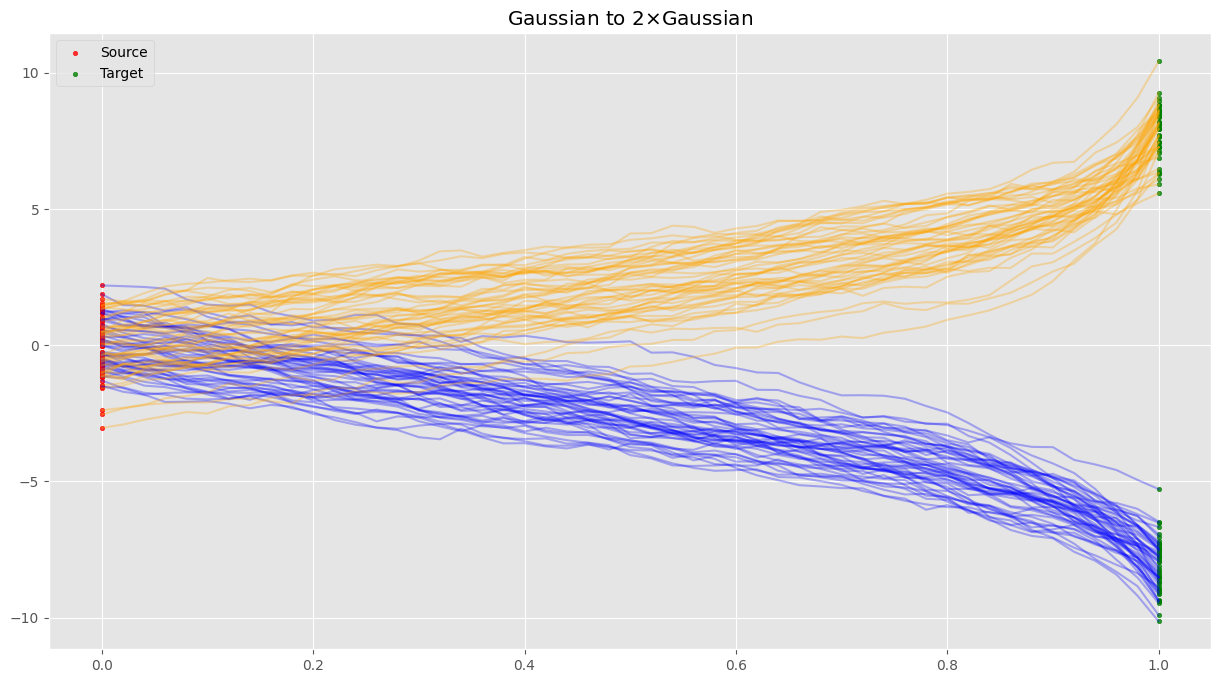

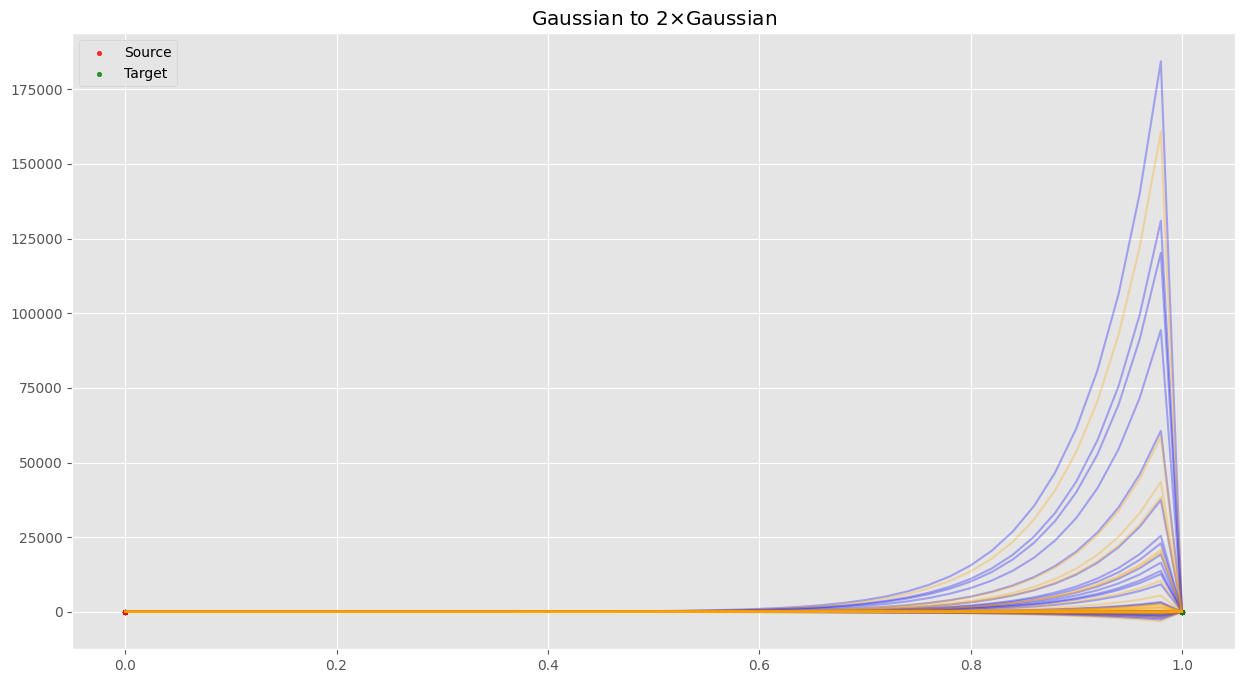

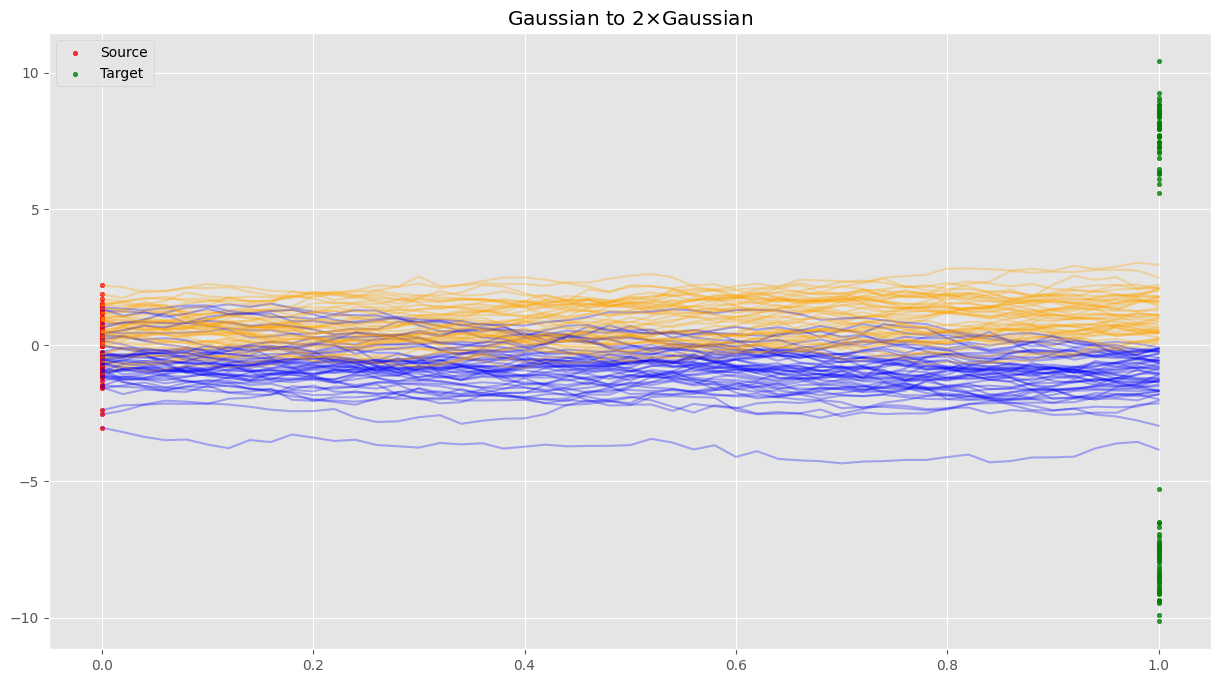

In [5]:
from utils.plot import plot_bridge, plot_t
# num_test = 100
# source_sample = X0.repeat(num_test, 1)
# target_sample = XT.repeat(num_test, 1)
source_sample = X0
target_sample = XT

backward_out = diffusion.simulate_bridge_backwards(
score_transition_net, source_sample, target_sample, epsilon, modify=True, full_score=True)
forward_out = diffusion.simulate_bridge_forwards(score_transition_net, score_marginal_net, source_sample,
                                    target_sample, epsilon, num_samples=1, modify=False, full_score=True, new_num_steps=None)
real_out = diffusion.simulate_process(source_sample)


fig, _ = plot_bridge(diffusion.time.numpy(), backward_out['trajectories'][:, :, 0].detach(
).numpy().T, source_sample.numpy(), target_sample.numpy(), show_rate=1, show_gt=False)
fig.show()
# fig.savefig(args.log_dir / 'bridge_backward.jpg')

fig, _ = plot_bridge(diffusion.time.numpy(), forward_out['trajectories'][:, :, 0].detach(
).numpy().T, source_sample.numpy(), target_sample.numpy(), show_rate=1, show_gt=False)
fig.show()
# fig.savefig(args.log_dir / 'bridge_forward.jpg')

fig, _ = plot_bridge(diffusion.time.numpy(), real_out['trajectories'][:, :, 0].detach(
).numpy().T, source_sample.numpy(), target_sample.numpy(), show_rate=1, show_gt=False)
fig.show()
# fig.savefig(args.log_dir / 'bridge_real.jpg')

In [6]:
# compare ESS
print('FD ESS%: ' + str(float(torch.mean(FD['ess']) * 100 / N)))
print('MDB ESS%: ' + str(float(torch.mean(MDB['ess']) * 100 / N)))
print('CDH ESS%: ' + str(float(torch.mean(CDH['ess']) * 100 / N)))
print('BDB ESS%: ' + str(float(torch.mean(BDB['ess']) * 100 / N)))
print('FDB ESS%: ' + str(float(torch.mean(FDB['ess']) * 100 / N)))
print('MBDB ESS%: ' + str(float(torch.mean(MBDB['ess']) * 100 / N)))
print('MFDB ESS%: ' + str(float(torch.mean(MFDB['ess']) * 100 / N)))


NameError: name 'FD' is not defined

In [ ]:
# compare RMSE of log-transition density 
print('FD RMSE: ' + str(float(torch.sqrt(torch.mean((FD['logestimate'] - log_transition_density)**2)))))
print('MDB RMSE: ' + str(float(torch.sqrt(torch.mean((MDB['logestimate'] - log_transition_density)**2)))))
print('CDH RMSE: ' + str(float(torch.sqrt(torch.mean((CDH['logestimate'] - log_transition_density)**2)))))
print('BDB RMSE: ' + str(float(torch.sqrt(torch.mean((BDB['logestimate'] - log_transition_density)**2)))))
print('FDB RMSE: ' + str(float(torch.sqrt(torch.mean((FDB['logestimate'] - log_transition_density)**2)))))
print('MBDB RMSE: ' + str(float(torch.sqrt(torch.mean((MBDB['logestimate'] - log_transition_density)**2)))))
print('MFDB RMSE: ' + str(float(torch.sqrt(torch.mean((MFDB['logestimate'] - log_transition_density)**2)))))

In [ ]:
# compare indepedent Meteropolis-Hastings acceptance rate
print('FD acceptance%: ' + str(float(torch.mean(FD['acceptrate'] * 100))))
print('MDB acceptance%: ' + str(float(torch.mean(MDB['acceptrate'] * 100))))
print('CDH acceptance%: ' + str(float(torch.mean(CDH['acceptrate'] * 100))))
print('BDB acceptance%: ' + str(float(torch.mean(BDB['acceptrate'] * 100))))
print('FDB acceptance%: ' + str(float(torch.mean(FDB['acceptrate'] * 100))))
print('MBDB acceptance%: ' + str(float(torch.mean(MBDB['acceptrate'] * 100))))
print('MFDB acceptance%: ' + str(float(torch.mean(MFDB['acceptrate'] * 100))))


In [ ]:
# store results
results = {'FD': FD, 
           'MDB': MDB, 
           'CDH': CDH, 
           'BDB': BDB, 
           'FDB': FDB,
           'MBDB': MBDB,
           'MFBD': MFDB}

torch.save(results, 'ou_dim1_T1.pt')